In [3]:
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [4]:

def polar_to_cartesian(r, theta_deg):
    """
    将极坐标 (r, θ) 转换为直角坐标 (x, y)
    θ 是以度为单位
    """
    theta_rad = math.radians(theta_deg)
    x = r * math.cos(theta_rad)
    y = r * math.sin(theta_rad)
    return x, y

def cartesian_to_polar(x, y):
    """
    将直角坐标 (x, y) 转换为极坐标 (r, θ)
    返回的 θ 以度为单位
    """
    r = math.sqrt(x**2 + y**2)
    theta_rad = math.atan2(y, x)
    theta_deg = math.degrees(theta_rad)
    return r, theta_deg


In [5]:

# 定义范围和间隔
x = np.arange(-3, 3.1, 0.1)
y = np.arange(-3, 3.1, 0.1)

# 生成网格
X, Y = np.meshgrid(x, y)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")


X shape: (61, 61), Y shape: (61, 61)


In [6]:
equivalence_all = {}
for dx in tqdm(range(30)):
    for dy in range(30):
        equivalence = []
        for i in range(len(x)):
            for j in range(len(y)):
                i2 = i + dx
                j2 = j + dy
                if i2 < 0 or i2 >= len(x) or j2 < 0 or j2 >= len(y):
                    continue
                x1 = x[i]
                y1 = y[j]
                x2 = x[i2]
                y2 = y[j2]
                r1, theta1 = cartesian_to_polar(x1, y1)
                r2, theta2 = cartesian_to_polar(x2, y2)
                equivalence.append(((r1, theta1), (r2, theta2)))
        equivalence_all[(dx, dy)] = equivalence


100%|██████████| 30/30 [00:03<00:00,  9.26it/s]


In [7]:
with open('cache/equivalence_all.pkl', 'wb') as f:
    pickle.dump(equivalence_all, f)

In [8]:
del equivalence_all

In [9]:

with open('cache/equivalence_all.pkl', 'rb') as f:
    equivalence_all = pickle.load(f)

### 直角坐标的三角形

In [10]:
def generate_triangle_with_cartision_coordinate(x0, y0, L, xs, ys):
    """
    Args:
        x: the x coordinate of the first point
        y: the y coordinate of the first point
        L: the length of the triangle side
    """
    A = np.array([x0, y0])

    # B: 向右走 1.5
    B = A + np.array([L, 0])

    # C: 从 A 到 B，逆时针旋转 60°
    theta = np.radians(60)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta),  np.cos(theta)]])
    C = A + rotation_matrix @ (B - A)
    # 3. 三边采样函数
    def sample_edge(p1, p2, step=0.05):
        length = np.linalg.norm(p2 - p1)
        num_points = int(length / step) + 1
        return np.linspace(p1, p2, num_points)

    # 4. 所有边上的点
    edge_points = np.vstack([
        sample_edge(A, B),
        sample_edge(B, C),
        sample_edge(C, A)
    ])

    # 5. 找最近格点
    def nearest_grid_point(px, py, x_vals, y_vals):
        ix = np.argmin(np.abs(x_vals - px))
        iy = np.argmin(np.abs(y_vals - py))
        return round(x_vals[ix], 2), round(y_vals[iy], 2)

    grid_points = [nearest_grid_point(px, py, xs, ys) for px, py in edge_points]

    # 去重
    unique_grid_points = sorted(set(grid_points))
    return unique_grid_points, A, B, C


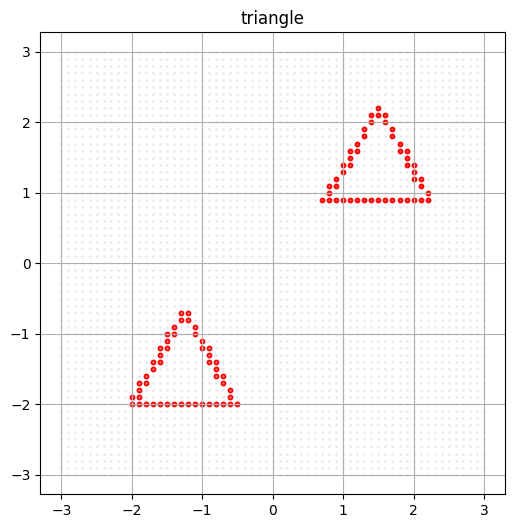

In [11]:
plt.figure(figsize=(6, 6))

points1, A, B, C = generate_triangle_with_cartision_coordinate(-2, -2, 1.5, x, y)

# plt.plot(*zip(*[A, B, C, A]), linestyle='-', color='blue', label='Triangle')
plt.scatter(*zip(*points1), color='red', s=10, label='Edge Grid Points')
plt.scatter(X, Y, s=1, color='lightgray', alpha=0.2)

points2, A, B, C = generate_triangle_with_cartision_coordinate(0.75, 0.88, 1.5, x, y)
# plt.plot(*zip(*[A, B, C, A]), linestyle='-', color='blue', label='Triangle')
plt.scatter(*zip(*points2), color='red', s=10, label='Edge Grid Points')
plt.scatter(X, Y, s=1, color='lightgray', alpha=0.2)  # 网格

plt.axis('equal')
plt.title("triangle")
# plt.legend()
plt.grid(True)
plt.show()


### 极坐标三角形

In [12]:
points1_polar = [cartesian_to_polar(x, y) for x, y in points1]
points2_polar = [cartesian_to_polar(x, y) for x, y in points2]

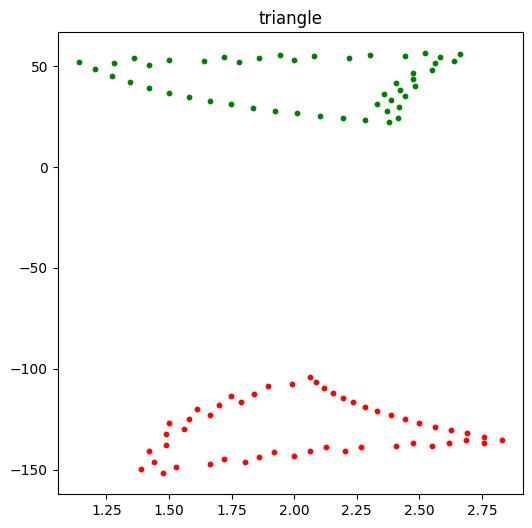

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(*zip(*points1_polar), color='red', s=10, label='Edge Grid Points')
plt.scatter(*zip(*points2_polar), color='green', s=10, label='Edge Grid Points')
# plt.scatter(X, Y, s=1, color='lightgray', alpha=0.2)  # 网格

# plt.axis('equal')
plt.title("triangle")
# plt.legend()
# plt.grid(True)
plt.show()

In [14]:
def find_mapping(equivalence, r, theta):
    _, (r2, theta2) = min(equivalence, key=lambda x: abs(x[0][0] - r) + abs(x[0][1] - theta))
    return r2, theta2


In [15]:
points_polar_all = []
for dx in range(25):
    dy = dx
    equivalence = equivalence_all[(dx, dy)]
    points2_polar = [find_mapping(equivalence, r, theta) for r, theta in points1_polar]
    points_polar_all.append(points2_polar)

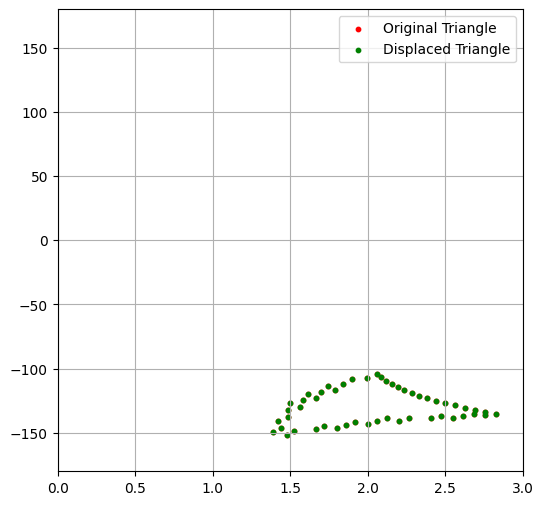

In [16]:

fig, ax = plt.subplots(figsize=(6, 6))

# 初始化图像元素（两个点集）
scat1 = ax.scatter([], [], color='red', s=10, label='Original Triangle')
scat2 = ax.scatter([], [], color='green', s=10, label='Displaced Triangle')

# ax.set_title("Triangle Animation")
ax.set_xlim(0, 3)
ax.set_ylim(-180, 180)
# ax.set_aspect('equal')
ax.legend()
ax.grid(True)

def init():
    scat1.set_offsets([])
    scat2.set_offsets([])
    return scat1, scat2

def update(frame):
    scat1.set_offsets(points1_polar)
    scat2.set_offsets(frame)
    return scat1, scat2

ani = FuncAnimation(fig, update, frames=points_polar_all, blit=True, interval=300)

In [17]:
HTML(ani.to_jshtml())

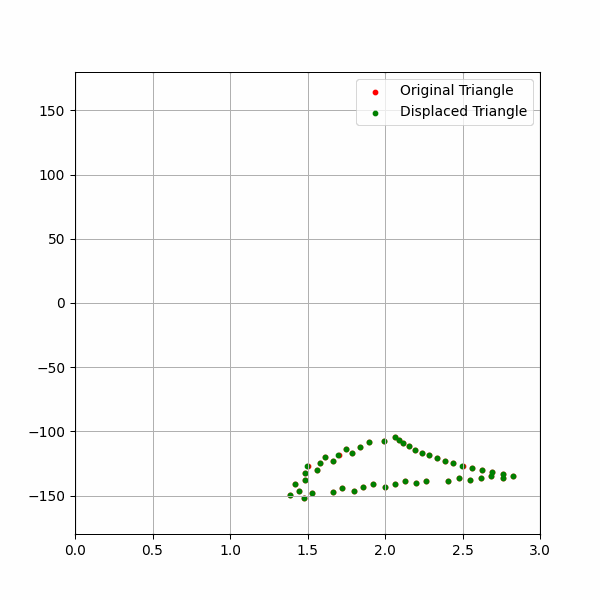

In [18]:
ani.save("triangle_animation.gif", writer="pillow", fps=5)

from IPython.display import Image
Image(filename="triangle_animation.gif")

In [19]:
len(points_polar_all)

25

In [20]:
XY_polar = np.array([cartesian_to_polar(x, y) for x, y in np.array([X, Y]).transpose(1, 2, 0).reshape(-1, 2)])

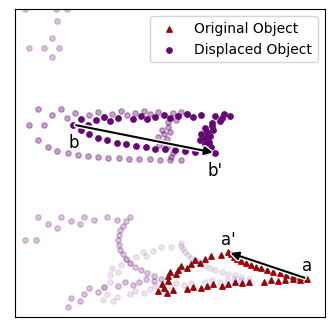

In [111]:

import matplotlib.patheffects as path_effects
arrow_width = 1.5
plt.figure(figsize=(4, 4))
plt.xlim(0, 3)
plt.ylim(-180, 180)
plt.scatter(*zip(*points1_polar), color='#94070A', s=15, label='Original Object', marker='^')
indices = [4, 10, 21]
for i, points2_polar in enumerate([points_polar_all[idx] for idx in indices]):
    plt.scatter(*zip(*points2_polar), color='#660874', s=15, alpha=i/len(indices)*0.4+0.1)
plt.scatter(*zip(*points_polar_all[-1]), color='#660874', s=15, label=f'Displaced Object', alpha=1)
points1_polar = points_polar_all[0]
point1 = points1_polar[0]
point2 = points1_polar[49]
plt.annotate('', xy=(point2[0], point2[1]), xytext=(point1[0], point1[1]), arrowprops=dict(arrowstyle='-|>', color='white', lw=arrow_width, path_effects=[
        path_effects.Stroke(linewidth=arrow_width+2, foreground='white'),
        path_effects.Normal()
    ]), fontsize=12)
plt.annotate('', xy=(point2[0], point2[1]), xytext=(point1[0], point1[1]), arrowprops=dict(arrowstyle='-|>', color='black', lw=arrow_width), fontsize=12)
plt.text(point1[0], point1[1]+5, 'a', ha='center', va='bottom', fontsize=12)
plt.text(point2[0], point2[1]+5, 'a\'', ha='center', va='bottom', fontsize=12)
points2_polar = points_polar_all[-1]
point1 = points2_polar[0]
point2 = points2_polar[49]
plt.annotate('', xy=(point2[0], point2[1]), xytext=(point1[0], point1[1]), arrowprops=dict(arrowstyle='-|>', color='white', lw=arrow_width, path_effects=[
        path_effects.Stroke(linewidth=arrow_width+2, foreground='white'),
        path_effects.Normal()
    ]), fontsize=12)
plt.annotate('', xy=(point2[0], point2[1]), xytext=(point1[0], point1[1]), arrowprops=dict(arrowstyle='-|>', color='black', lw=arrow_width), fontsize=12)
plt.text(point1[0], point1[1]-10, 'b', ha='center', va='top', fontsize=12)
plt.text(point2[0], point2[1]-10, 'b\'', ha='center', va='top', fontsize=12)
plt.legend()
plt.xticks([])
plt.yticks([]) 
plt.savefig("internal_displacement.pdf", bbox_inches='tight')
plt.show()

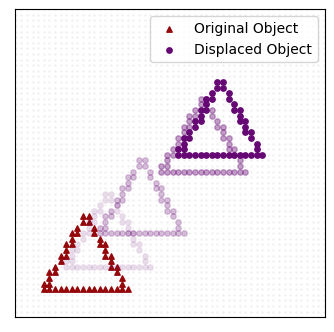

In [34]:
plt.figure(figsize=(4, 4))

plt.scatter(X, Y, s=1, color='lightgray', alpha=0.2)
points1_catesian = [polar_to_cartesian(r, theta) for r, theta in points1_polar]
# plt.plot(*zip(*[A, B, C, A]), linestyle='-', color='blue', label='Triangle')
plt.scatter(*zip(*points1_catesian), color='#94070A', s=15, label='Original Object', marker='^')

for i, points2_polar in enumerate([points_polar_all[idx] for idx in indices]):
    points2_catesian = [polar_to_cartesian(r, theta) for r, theta in points2_polar]
    plt.scatter(*zip(*points2_catesian), color='#660874', s=15, alpha=i/len(indices)*0.4+0.1)
# plt.plot(*zip(*[A, B, C, A]), linestyle='-', color='blue', label='Triangle')
points2_catesian = [polar_to_cartesian(r, theta) for r, theta in points_polar_all[-1]]
plt.scatter(*zip(*points2_catesian), color='#660874', s=15, label=f'Displaced Object', alpha=1)

plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlim(-2.5, 3)
plt.ylim(-2.5, 3)
# plt.title("triangle")
plt.legend()
plt.grid(False)
plt.savefig("external_displacement.pdf", bbox_inches='tight')
plt.show()